In [2]:
import os.path

import numpy as np
from bayes_implicit_solvent.molecule import Molecule
from simtk import unit


def sample_path_to_unitted_snapshots(path_to_npy_samples):
    xyz = np.load(path_to_npy_samples)
    traj = [snapshot * unit.nanometer for snapshot in xyz]
    return traj


from glob import glob
from pkg_resources import resource_filename

data_path = resource_filename('bayes_implicit_solvent',
                              'data')
ll = 'gaussian'  # or 'student-t'
randomize_theta0 = False

path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                           'vacuum_samples/vacuum_samples_*.npy')
paths_to_samples = glob(path_to_vacuum_samples)
print('number of molecules being considered: {}'.format(len(paths_to_samples)))


def extract_cid_key(path):
    i = path.find('mobley_')
    j = path.find('.npy')
    return path[i:j]


cids = list(map(extract_cid_key, paths_to_samples))

mols = []

from bayes_implicit_solvent.freesolv import cid_to_smiles

for path in paths_to_samples:
    cid = extract_cid_key(path)
    smiles = cid_to_smiles[cid]
    vacuum_samples = sample_path_to_unitted_snapshots(path)
    mol = Molecule(smiles, vacuum_samples=vacuum_samples)
    mols.append(mol)

number of molecules being considered: 642


In [11]:
from bayes_implicit_solvent.gb_models.obc2_parameters import obc2_model

obc2_model.remove_node('[#14]')

type_slices = [obc2_model.apply_to_molecule(mol.mol) for mol in mols]

def construct_arrays(theta):
    n = int(len(theta) / 2)
    radii, scales = theta[:n], theta[n:]

    parameterized_list = []
    for i in range(len(mols)):
        parameterized_list.append((radii[type_slices[i]], scales[type_slices[i]]))
    return parameterized_list

In [12]:
theta0 = np.array([0.15 , 0.12 , 0.17 , 0.155, 0.15 , 0.15 , 0.185, 0.18 , 0.8  ,
       0.85 , 0.72 , 0.79 , 0.85 , 0.88 , 0.86 , 0.96 ])
theta0

array([0.15 , 0.12 , 0.17 , 0.155, 0.15 , 0.15 , 0.185, 0.18 , 0.8  ,
       0.85 , 0.72 , 0.79 , 0.85 , 0.88 , 0.86 , 0.96 ])

In [13]:
len(theta0)

16

In [14]:
arrays = construct_arrays(theta0)

In [15]:
i = np.random.randint(len(mols))

In [18]:
mol = mols[i]
radii, scaling_factors = arrays[i]

In [19]:
from bayes_implicit_solvent.solvation_free_energy import predict_solvation_free_energy

In [43]:
uncs = []
for mol in mols:
    uncs.append(mol.experimental_uncertainty)

(array([102.,  26.,   6., 469.,   4.,  11.,   1.,   6.,   0.,  17.]),
 array([0.05063414, 0.37131701, 0.69199988, 1.01268275, 1.33336562,
        1.65404849, 1.97473137, 2.29541424, 2.61609711, 2.93677998,
        3.25746285]),
 <a list of 10 Patch objects>)

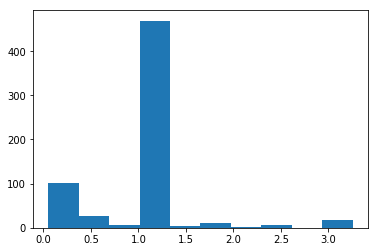

In [44]:
plt.hist(uncs)

In [45]:
min(uncs)

0.05063413756414972

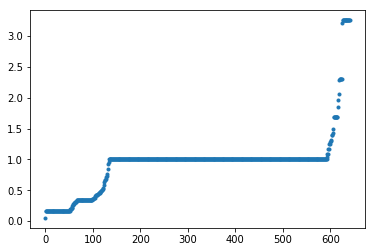

In [47]:
plt.plot(sorted(uncs), '.')

In [40]:
preds = []

N = 25

for _ in range(100):
    T = len(mol.vacuum_traj)
    resampled_traj = [mol.vacuum_traj[i] for i in np.random.randint(0,T,N)]
    
    preds.append(predict_solvation_free_energy(mol.implicit_sim, resampled_traj, radii, scaling_factors))
preds = np.array(preds)

In [41]:
len(resampled_traj)

25

(array([ 1.,  5., 11.,  9., 15., 22., 11., 11., 11.,  4.]),
 array([-1.88498878, -1.8716259 , -1.85826301, -1.84490013, -1.83153725,
        -1.81817437, -1.80481148, -1.7914486 , -1.77808572, -1.76472283,
        -1.75135995]),
 <a list of 10 Patch objects>)

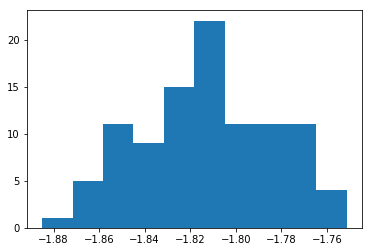

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_implicit_solvent.utils import remove_top_right_spines
%matplotlib inline

plt.hist(preds[:,0])

In [38]:
np.std(preds[:,0])

0.04966223600127494

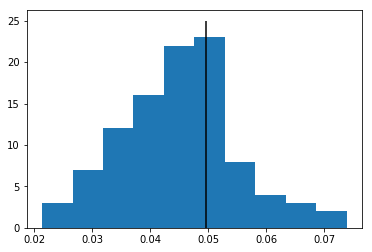

In [39]:
plt.hist(preds[:,1])
plt.vlines(np.std(preds[:,0]), 0, 25)

In [23]:
mol.vacuum_traj[np.random.randint(0,T,T)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [24]:
mol.vacuum_traj

[Quantity(value=array([[ 1.58519399, -0.97989981,  1.37890752],
        [ 1.60341712, -0.95031922,  1.51140098],
        [ 1.72330073, -0.98341568,  1.57296923],
        [ 1.82389861, -1.04605686,  1.49813954],
        [ 1.80271125, -1.06903493,  1.36222238],
        [ 1.68182738, -1.04143885,  1.29663824],
        [ 1.98842326, -1.07062333,  1.57059188],
        [ 1.49160974, -0.95152185,  1.34252308],
        [ 1.526122  , -0.89982545,  1.56373011],
        [ 1.73881291, -0.97024993,  1.67591402],
        [ 1.88648479, -1.11587309,  1.30604182],
        [ 1.67829297, -1.06717764,  1.19097007]]), unit=nanometer),
 Quantity(value=array([[ 1.69373385, -1.25009857,  1.65680843],
        [ 1.8359275 , -1.25883332,  1.65290968],
        [ 1.90193339, -1.15565639,  1.58385489],
        [ 1.83255144, -1.05229256,  1.51979231],
        [ 1.69387727, -1.03884537,  1.53583397],
        [ 1.61988026, -1.14183207,  1.59764526],
        [ 1.93025327, -0.93406659,  1.41977848],
        [ 1.64307202